In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import fxtool as ft


In [26]:
def get_change_list(data, rate_types=["Open", "Close"]):
    
    pre_close = None
    change_list = []
    for o,c in zip(data[rate_types[0]],data[rate_types[1]]):
        if pre_close:
            change = pre_close - o
            change_list.append(change)
        else:
            change_list.append(None)
        pre_close = c
    return change_list

In [90]:
def get_candle_list(data, rate_types=["Open", "Close"]):
    
    change_list = []
    for o,c in zip(data[rate_types[0]],data[rate_types[1]]):
        change =  np.log(c/o)
        change_list.append(change)
    return change_list


In [97]:
data = ft.read_csv([
        "201506",
        "201505",
        "201504",
        "201503","201502","201501","201412","201411"
    ])

201506
201505
201504
201503
201502
201501
201412
201411


In [110]:
ohlc = ft.get_ohlc(data, '1H')

ohlc["Change(Close)"] =  ohlc["Close"].diff()
ohlc["Change(Open)"] = ohlc["Open"].diff()
ohlc["Change(Open-Close)"] = get_candle_list(ohlc)

ohlc.describe()

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Open,High,Low,Close,Change(Close),Change(Open),Change(Open-Close)
count,4073.000000,4073.000000,4073.000000,4073.000000,4072.000000,4072.000000,4073.000000
mean,119.657768,119.751837,119.561439,119.661027,0.002320,0.002401,0.000028
std,2.280178,2.269068,2.290917,2.277999,0.139771,0.140774,0.001164
min,112.636000,112.724000,112.571000,112.635000,-1.544000,-1.543000,-0.012467
25%,118.461000,118.566000,118.345000,118.467000,NaN,NaN,-0.000477
50%,119.518000,119.609000,119.428000,119.519000,NaN,NaN,0.000033
75%,120.563000,120.663000,120.482000,120.565000,NaN,NaN,0.000547
max,125.681000,125.852000,125.612000,125.680000,1.331000,1.548000,0.013126


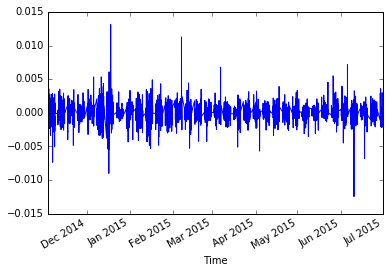

In [111]:
ohlc["Change(Open-Close)"].dropna().plot()

In [112]:
ohlc['change_positive'] = 0
ohlc.ix[ohlc['Change(Open-Close)'] >= 0, 'change_positive'] = 1
ohlc['change_negative'] = 0
ohlc.ix[ohlc['Change(Open-Close)'] < 0, 'change_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'change_positive', 
    'change_negative',
    'change_1', 
    'change_2', 
    'change_3',
    ]
)

for i in range(7, len(ohlc)):
    change_positive = ohlc['change_positive'].ix[i]
    change_negative = ohlc['change_negative'].ix[i]
    change_1 = ohlc['Change(Open-Close)'].ix[i-1]
    change_2 = ohlc['Change(Open-Close)'].ix[i-2]
    change_3 = ohlc['Change(Open-Close)'].ix[i-3]
    
    training_test_data = training_test_data.append(
        {
            'change_positive': change_positive,
            'change_negative': change_negative,
            'change_1': change_1,
            'change_2': change_2,
            'change_3': change_3
        },
        ignore_index=True
    )
    if i % 1000 == 0:
        print("{}".format(i))

training_test_data.head()

1000
2000
3000
4000


,change_positive,change_negative,change_1,change_2,change_3
0,0.0,1.0,-0.000053,0.000222,0.000018
1,0.0,1.0,-0.000213,-0.000053,0.000222
2,1.0,0.0,-0.000621,-0.000213,-0.000053
3,1.0,0.0,0.001216,-0.000621,-0.000213
4,1.0,0.0,0.000674,0.001216,-0.000621


In [114]:
predictors_tf = training_test_data[training_test_data.columns[2:]]

classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]

test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

,change_1,change_2,change_3
count,3252.000000,3252.000000,3252.000000
mean,0.000024,0.000024,0.000024
std,0.001180,0.001180,0.001180
min,-0.009021,-0.009021,-0.009021
25%,-0.000497,-0.000497,-0.000496
50%,0.000025,0.000025,0.000025
75%,0.000565,0.000565,0.000565
max,0.013126,0.013126,0.013126


In [115]:
import tensorflow as tf

keep_prob = 1.0
hidden_num1 = 50
hidden_num2 = 25


sess1 = tf.Session()

num_predictors = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)
print("num_predictor: {}".format( num_predictors))
print("num_classes: {}".format( num_classes))

feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, num_classes])

weights1 = tf.Variable(tf.truncated_normal([num_predictors, hidden_num1], stddev=0.0001))
biases1 = tf.Variable(tf.ones([hidden_num1]))
hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)

weights2 = tf.Variable(tf.truncated_normal([hidden_num1, hidden_num2], stddev=0.0001))
biases2 = tf.Variable(tf.ones([hidden_num2]))
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)

dropout = tf.nn.dropout(hidden_layer_2, keep_prob)

weights3 = tf.Variable(tf.truncated_normal([hidden_num2, num_classes], stddev=0.0001))
biases3 = tf.Variable(tf.ones([num_classes]))
model = tf.nn.softmax(tf.matmul(dropout, weights3) + biases3)
hidden_num2
cost = -tf.reduce_sum(actual_classes*tf.log(model))

train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess1.run(init)

num_predictor: 3
num_classes: 2


In [ ]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 300001):
  sess1.run(
    train_op1, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    accuracy_value, cost_value = sess1.run(
      [accuracy,cost],
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )
    print( "{} :{} : {}".format(i, accuracy_value, cost_value))

5000 :0.5138376355171204 : 2252.384765625
10000 :0.5138376355171204 : 2250.586669921875
15000 :0.5166051387786865 : 2250.256591796875
20000 :0.5162976384162903 : 2249.80859375
25000 :0.5156826376914978 : 2249.355712890625
30000 :0.5172201991081238 : 2248.95361328125
35000 :0.5178351998329163 : 2248.720947265625
40000 :0.5193727016448975 : 2248.640869140625
45000 :0.5184502005577087 : 2248.4404296875
50000 :0.5193727016448975 : 2247.960693359375
55000 :0.5190652012825012 : 2247.71875
